In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b05279dd-124a-ad13-cb09-400605a96725)


In [1]:
# get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [3]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
# Create a function to read lines of a document.
def get_lines(filenames):
  '''
  Read text file and returns lines of text of the file as a list.
  Args:
  filenames: target filepath to read.

  '''
  with open(filenames, 'r') as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:40]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
      #print(abstract_line_split)

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:

# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)



CPU times: user 503 ms, sys: 115 ms, total: 618 ms
Wall time: 627 ms


(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

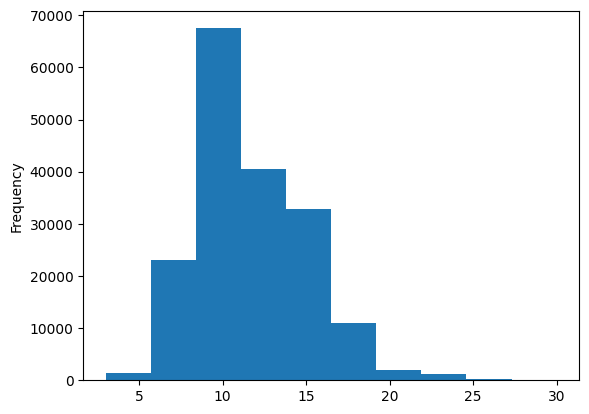

In [13]:
train_df.total_lines.plot.hist();

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [22]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [19]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-15 03:21:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-15 03:21:05 (94.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

# Calculate the baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [20]:
# preparing data for our deep sequence models
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [21]:
# How long is each sentence on average.
sent_lengths = [len(sentence.split()) for sentence in train_sentences]
ave_sen_lengths = np.mean(sent_lengths)
ave_sen_lengths


26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

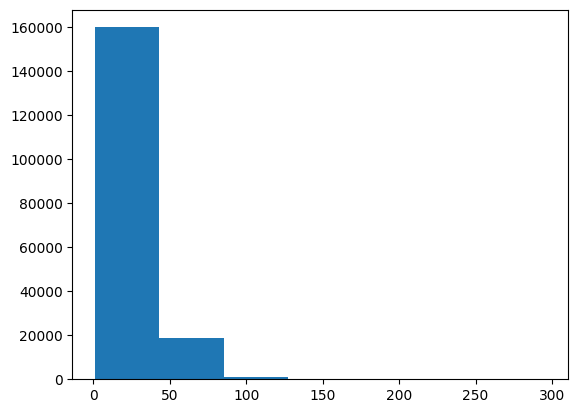

In [22]:
# What's the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lengths, bins=7)

In [23]:
# find min and max sentence length
min_sen = min(sent_lengths)
max_sen = max(sent_lengths)
min_sen, max_sen

(1, 296)

In [24]:
# How long of a sentence cover 95% of the lengths?
output_seq_len = int(np.percentile(sent_lengths, 95))
output_seq_len
# 55, so in 0-55 lengths there are 55% sentences

55

In [25]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [26]:
# Create text Vectorizer

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55
                                    )

In [27]:
text_vectorizer.adapt(train_sentences)

In [28]:
import random
# check a random sentence
print(f'random sentence: {random.choice(train_sentences)}')
print(f'After text_vectorizer: {text_vectorizer([random.choice(train_sentences)])}')

random sentence: separate sets of forty fresh-frozen tibialis tendon allografts ( four from each of ten donors ) and forty bisected bone-patellar tendon-bone ( btb ) allografts ( four from each of ten donors ) were randomly assigned to four study groups .
After text_vectorizer: [[  25 1011   21  253  301  684   66 1239   11 8214  561 3901   20  317
   861   19 1605  637 2635  977    6  218    2  335   71    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [29]:
# Go through the vocabulay of text_vectorizer
words_in_vocab = text_vectorizer.get_vocabulary()
print(f'lengths of vocabulary: {len(words_in_vocab)}')
print(f'Most common words: {words_in_vocab[:10]}')
print(f'Lowest common words: {words_in_vocab[-10:]}')

lengths of vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Lowest common words: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [30]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [31]:
# Create embedding layer

embedding = layers.Embedding(input_dim=len(words_in_vocab),
                             output_dim=128,
                             # Use masking to handle variable sequence lengths (save space)
                             mask_zero=True,
                             name='Embedding_layer_1'

                             )

In [32]:
print(f'random sentence: {random.choice(train_sentences)}')
print(f'After text_vectorizer: {text_vectorizer([random.choice(train_sentences)])}')
print(f'After Embedding: {embedding(text_vectorizer([random.choice(train_sentences)]))}')

random sentence: overall , right fle patients demonstrated decreased bold activity in the epileptic hemisphere and increased bold activity in the healthy hemisphere compared to controls ( p < @ ) .
After text_vectorizer: [[ 704  337 2888    6 1143    5    2 2142   13   55    8 1422  187  422
  2806 6512    4 1548   42  337    5    2    3 2142   24   83   34    7
     3   14    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
After Embedding: [[[ 0.04958506  0.00801444 -0.04524849 ...  0.01713461 -0.02573509
    0.03126055]
  [-0.00876214  0.00676052 -0.03607341 ...  0.00430969  0.03598421
    0.03586402]
  [-0.02518591 -0.04997201 -0.00667948 ...  0.04897739  0.02408159
   -0.04521871]
  ...
  [-0.04708579 -0.04910321 -0.00344263 ...  0.03521364 -0.03023777
   -0.01270764]
  [-0.04708579 -0.04910321 -0.00344263 ...  0.03521364 -0.03023777
   -0.01270764]
  [-0.04708579 -0.04910321 -0.00344263 ...  0.03521364 -

In [33]:
em_sen = embedding(text_vectorizer([random.choice(train_sentences)]))

In [34]:
em_sen

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.04307674,  0.04189645,  0.00402277, ..., -0.00020071,
          0.02460999,  0.006919  ],
        [ 0.02376777,  0.04082996,  0.01755014, ..., -0.03327149,
          0.04055538,  0.02602582],
        [ 0.02978027, -0.01334767, -0.03745755, ..., -0.01488671,
          0.00351142,  0.02793033],
        ...,
        [-0.04708579, -0.04910321, -0.00344263, ...,  0.03521364,
         -0.03023777, -0.01270764],
        [-0.04708579, -0.04910321, -0.00344263, ...,  0.03521364,
         -0.03023777, -0.01270764],
        [-0.04708579, -0.04910321, -0.00344263, ...,  0.03521364,
         -0.03023777, -0.01270764]]], dtype=float32)>

In [35]:
em_sen[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04307674,  0.04189645,  0.00402277, -0.01419185,  0.04170842,
        0.00433402,  0.02388858, -0.04911342, -0.03786535,  0.03767817,
       -0.04358622,  0.03992236,  0.00591872, -0.02062041, -0.03584659,
        0.02537392, -0.0109495 ,  0.00977166,  0.00333516, -0.02243373,
        0.0428388 ,  0.00431782,  0.03794918,  0.03119208, -0.03424293,
       -0.03029953, -0.02681537,  0.01126418,  0.03060737,  0.01594028,
       -0.02257484,  0.02301344,  0.01908186,  0.03304812,  0.04376919,
        0.01234287,  0.02903542,  0.00758206, -0.02487522, -0.03798032,
       -0.00979614, -0.00492971, -0.04869921, -0.02540051, -0.02958986,
        0.02324224, -0.02939138,  0.01098937,  0.00965779,  0.01944849,
       -0.01939275,  0.0338539 , -0.01277151,  0.00593721,  0.00646069,
        0.02988788, -0.02635217, -0.04455631,  0.02201713,  0.03636315,
       -0.01867082, -0.04772978,  0.02284808, -0.03521711, -0.02248996,
       -0.006130

In [36]:
# Create Dataset
# Turn our data into tesorflow dataset
train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [37]:
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take tensorSlicesDataset's and turn them into prefetch batchs
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
train_data



<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [59]:
# Create a Model Conv1D
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1')

#Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [60]:
# Fit the model
history_model_1 = model_1.fit(train_data,
                              epochs=3,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

Epoch 1/3
5627/5627 [==============================] - 95s 15ms/step - loss: 0.6187 - accuracy: 0.7737 - val_loss: 0.5370 - val_accuracy: 0.8093
Epoch 2/3
5627/5627 [==============================] - 38s 7ms/step - loss: 0.4558 - accuracy: 0.8399 - val_loss: 0.5337 - val_accuracy: 0.8105
Epoch 3/3
5627/5627 [==============================] - 39s 7ms/step - loss: 0.3754 - accuracy: 0.8711 - val_loss: 0.5678 - val_accuracy: 0.8060


In [82]:
model_1.evaluate(val_data)

945/945 [==============================] - 4s 4ms/step - loss: 0.5678 - accuracy: 0.8060


[0.5677930116653442, 0.8059711456298828]

In [70]:
#Feature extraction with pretrained token embeddings
import tensorflow_hub as hub
tf_hub_feature_extractor_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                                trainable=False,
                                                name='Universal_Sentence_Encoder')

In [86]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_feature_extractor_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the early years education program ( eyep ) is a new program offered by the children 's protection society ( cps ) in melbourne , australia .

Sentence after embedding:
[ 0.05818819  0.03865222 -0.04718373  0.00301616 -0.08466959  0.00691801
 -0.05429239  0.04822437  0.01979704 -0.06144058  0.01889988 -0.02041066
 -0.0242719   0.02308807  0.08125384  0.01227988 -0.08505967  0.01640969
  0.00438563 -0.08342049 -0.07079334  0.04048215  0.06388274  0.00464137
  0.04720711  0.06750894 -0.04385734  0.02233844  0.02994653 -0.03594545] (truncated output)...

Length of sentence embedding:
512


In [89]:
# Model_2 based on USE
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_feature_extractor_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [90]:
history_model_2 = model_2.fit(train_data,
                              epochs=3,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

Epoch 1/3
5627/5627 [==============================] - 90s 15ms/step - loss: 0.7250 - accuracy: 0.7234 - val_loss: 0.6534 - val_accuracy: 0.7516
Epoch 2/3
5627/5627 [==============================] - 97s 17ms/step - loss: 0.6330 - accuracy: 0.7591 - val_loss: 0.6212 - val_accuracy: 0.7624
Epoch 3/3
5627/5627 [==============================] - 78s 14ms/step - loss: 0.5994 - accuracy: 0.7732 - val_loss: 0.6073 - val_accuracy: 0.7688


In [93]:
 #Feature extraction with pretrained token embeddings (BERT)
import tensorflow_hub as hub
tf_hub_feature_extractor_layer_bert = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                                                trainable=False,
                                                name='bert_Sentence_Encoder')

In [106]:
!pip3 install --quiet tensorflow-text

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

def bert_encoder(sentences):


  # Load the BERT encoder and preprocessing models
  preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
  bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

  # Convert the sentences to bert inputs
  bert_inputs = preprocess(sentences)

  # Feed the inputs to the model to get the pooled and sequence outputs
  bert_outputs = bert(bert_inputs, training=False)
  pooled_output = bert_outputs['pooled_output']
  sequence_output = bert_outputs['sequence_output']
  return sequence_output


In [107]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence =bert_encoder([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
one hundred and twenty-eight postoperative patients with breast cancer who underwent anthracycline-based adjuvant chemotherapy were enrolled in this prospective study , and they were randomized into @ groups , i.e. , treatment group , which received the therapy of cik cells transfusion , and control group , which was given regular follow-up .

Sentence after embedding:
[[-0.2753387  -0.41851962 -0.7423059  ... -0.4553426  -0.59354395
  -1.2426862 ]
 [ 0.9287292   0.3461113   1.0081347  ... -0.34853232 -1.1578782
  -0.84712374]
 [ 0.2645735  -0.5994086   1.6154273  ...  0.00574929 -0.39569685
   0.2647885 ]
 ...
 [ 0.7752085  -1.212878    0.85731053 ... -0.28619462  0.30086946
  -0.30837545]
 [ 0.561916   -0.29641524 -0.23648548 ...  0.88242435 -0.09103706
   0.9649954 ]
 [ 0.34886724 -0.42994094 -0.6037212  ... -0.23735207 -0.51429003
   0.29722053]] (truncated output)...

Length of sentence embedding:
128


In [110]:
# Model_3 based on BERT
inputs = layers.Input(shape=[], dtype=tf.string)
x = bert_encoder(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_bert')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

TypeError: ignored

In [ ]:
history_model_2 = model_2.fit(train_data,
                              epochs=3,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

In [114]:
# Create model using the Sequential API
model_3 = tf.keras.Sequential([
  bert_encoder(train_data), # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_3")

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_model_3 = model_3.fit(train_data,
                              epochs=3,
                              steps_per_epoch=len(train_data),
                              validation_data=val_data,
                              validation_steps=len(val_data))

ValueError: ignored

character embeddings

In [46]:
# Make a function to split sentences to character
def split_chars(text):
  return ' '.join(list(text))

In [47]:
# test the function
split_chars('Tushar Kumar Mahata')

'T u s h a r   K u m a r   M a h a t a'

In [49]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [45]:
train_chars[:50]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [50]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [51]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
ave_char_len = np.mean(char_lens)
ave_char_len


149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

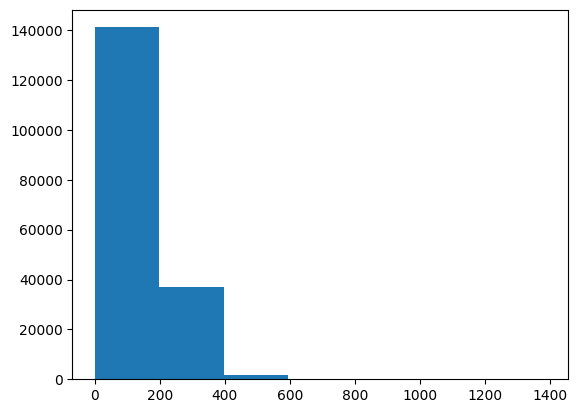

In [53]:
plt.hist(char_lens, bins=7)

In [55]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [56]:
# Get all keyboard characters for char label embedding
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [57]:
len(alphabets)

68

In [60]:
NUM_CHAR_TOKENS = len(alphabets) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [61]:
char_vectorizer.adapt(train_chars)

In [62]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [64]:
# Test out character vectorizer
random_train_chars_sen = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars_sen}")
print(f"\nLength of chars: {len(random_train_chars_sen.split())}")
vectorized_chars = char_vectorizer([random_train_chars_sen])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   p r o p o r t i o n   o f   p a t i e n t s   a c h i e v i n g   h b a @ c   <   @   %   (   @   m m o l / m o l   )   w a s   @   %   w i t h   s a x a + d a p a + m e t   v e r s u s   @   %   w i t h   s a x a + m e t   a n d   @   %   w i t h   d a p a + m e t   .

Length of chars: 111

Vectorized chars:
[[ 3 13  2 14  8  7 14  7  8  3  4  7  6  7 17 14  5  3  4  2  6  3  9  5
  11 13  4  2 21  4  6 18 13 22  5 11 15 15  7 12 15  7 12 20  5  9 20  4
   3 13  9  5 24  5 10  5 14  5 15  2  3 21  2  8  9 16  9 20  4  3 13  9
   5 24  5 15  2  3  5  6 10 20  4  3 13 10  5 14  5 15  2  3  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [65]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars_sen}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars_sen]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   p r o p o r t i o n   o f   p a t i e n t s   a c h i e v i n g   h b a @ c   <   @   %   (   @   m m o l / m o l   )   w a s   @   %   w i t h   s a x a + d a p a + m e t   v e r s u s   @   %   w i t h   s a x a + m e t   a n d   @   %   w i t h   d a p a + m e t   .

Embedded chars (after vectorization and embedding):
[[[ 0.00114664  0.04462695  0.02517153 ... -0.01360109  0.00356365
   -0.04688704]
  [ 0.04432212  0.04661785  0.04014924 ...  0.03559122 -0.00912701
   -0.01032032]
  [ 0.01153892  0.03117155 -0.00099609 ...  0.02635356 -0.04376732
    0.02910657]
  ...
  [-0.02958038 -0.0147341  -0.00570388 ...  0.01811183  0.03327246
   -0.03058901]
  [-0.02958038 -0.0147341  -0.00570388 ...  0.01811183  0.03327246
   -0.03058901]
  [-0.02958038 -0.0147341  -0.00570388 ...  0.01811183  0.03327246
   -0.03058901]]]

Character embedding shape: (1, 290, 25)


In [66]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_4_conv1D_char_embedding")

# Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [68]:
# Fit the model on chars only
model_4_history = model_4.fit(train_char_dataset,
                              steps_per_epoch=len(train_char_dataset),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=len(val_char_dataset))

Epoch 1/3
5627/5627 [==============================] - 131s 23ms/step - loss: 0.8894 - accuracy: 0.6540 - val_loss: 0.7850 - val_accuracy: 0.6981
Epoch 2/3
5627/5627 [==============================] - 127s 23ms/step - loss: 0.7450 - accuracy: 0.7176 - val_loss: 0.7430 - val_accuracy: 0.7153
Epoch 3/3
5627/5627 [==============================] - 128s 23ms/step - loss: 0.7129 - accuracy: 0.7308 - val_loss: 0.7248 - val_accuracy: 0.7243


In [71]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_feature_extractor_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_token_and_char_embeddings")

In [72]:
model_5.summary()

Model: "model_5_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_Sentence_Encoder  (None, 512)                  2567978 

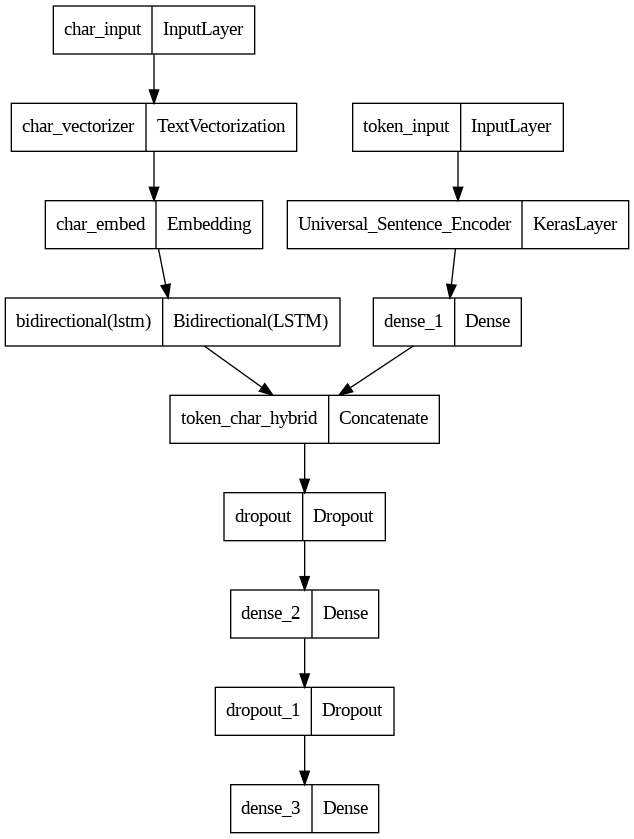

In [73]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [74]:

# Compile token char model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [75]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [76]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_5_history = model_5.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=len(train_char_token_dataset),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=len(val_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 1368s 242ms/step - loss: 0.7546 - accuracy: 0.7113 - val_loss: 0.6202 - val_accuracy: 0.7662
Epoch 2/3
 998/5627 [====>.........................] - ETA: 17:50 - loss: 0.6836 - accuracy: 0.7405